In [1]:
# ===============================================================
# NETWORK INTRUSION DETECTION SYSTEM (IDS)
# Using Machine Learning + Ensemble
# Dataset: UNSW-NB15
# ===============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from os import path

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, mean_squared_error, mean_absolute_error
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# ===========================
# LOAD DATASET
# ===========================
print("\nLoading UNSW-NB15 dataset...")
data = pd.read_csv("datasets/UNSW_NB15.csv")
print("Dataset shape:", data.shape)

print("\nSample rows:")
print(data.head())

# ===========================
# CLEAN MISSING VALUES
# ===========================
print("\nCleaning missing values...")
data["service"] = data["service"].replace("-", np.nan)
data.dropna(inplace=True)

print("After cleaning:", data.shape)

# Check class distributions
print("\nAttack Category Distribution:")
print(data["attack_cat"].value_counts())



Loading UNSW-NB15 dataset...
Dataset shape: (175341, 45)

Sample rows:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_sr

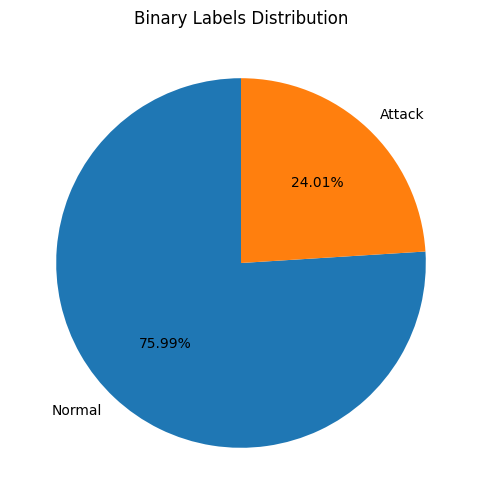

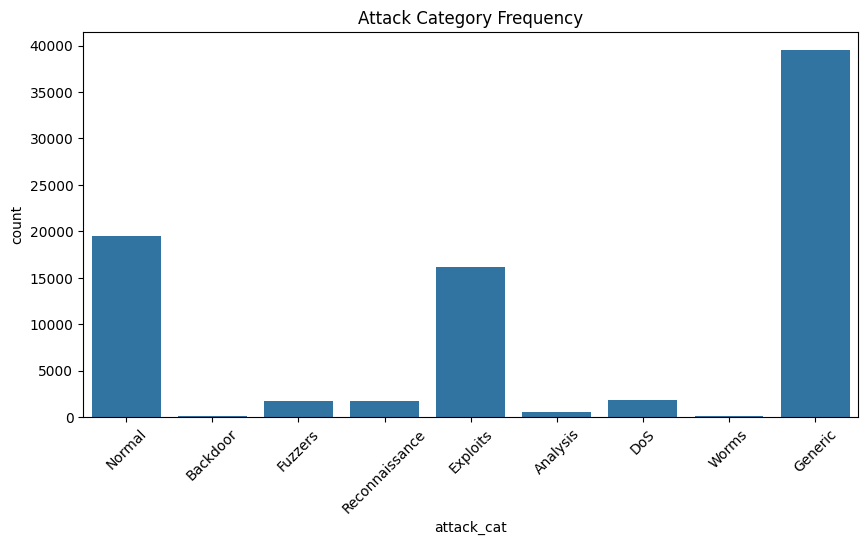

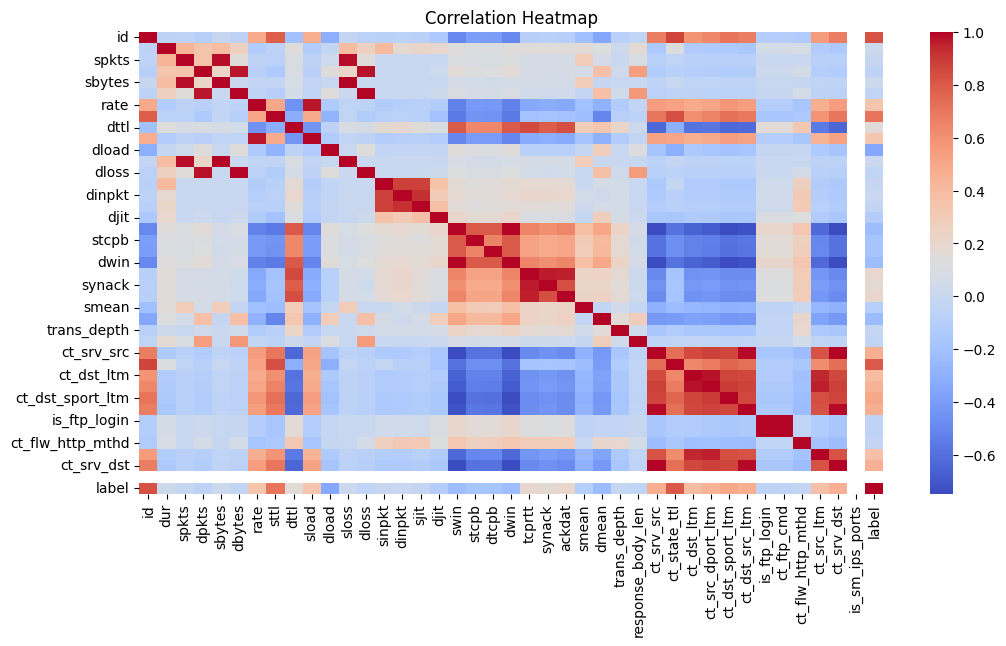

In [3]:
# ===========================
# BINARY LABEL PIE CHART
# ===========================
plt.figure(figsize=(6,6))
plt.pie(data["label"].value_counts(),
        labels=["Normal", "Attack"],
        autopct="%0.2f%%",
        startangle=90)
plt.title("Binary Labels Distribution")
plt.show()

# ===========================
# MULTI-CLASS LABEL BAR GRAPH
# ===========================
plt.figure(figsize=(10,5))
sns.countplot(x=data["attack_cat"])
plt.xticks(rotation=45)
plt.title("Attack Category Frequency")
plt.show()

# ===========================
# CORRELATION HEATMAP (TOP FEATURES)
# ===========================
plt.figure(figsize=(12,6))
sns.heatmap(data.select_dtypes(include=["int64","float64"]).corr(),
            cmap="coolwarm",
            cbar=True)
plt.title("Correlation Heatmap")
plt.show()


In [4]:
# ===========================
# ENCODE CATEGORICAL COLUMNS
# ===========================
print("\nEncoding categorical attributes...")
cat_cols = data.select_dtypes(include=["object"]).columns
le = LabelEncoder()

for col in cat_cols:
    data[col] = le.fit_transform(data[col])

print("\nEncoding completed. Columns encoded:", list(cat_cols))



Encoding categorical attributes...

Encoding completed. Columns encoded: ['proto', 'service', 'state', 'attack_cat']


In [5]:
# ===========================
# NORMALIZE NUMERIC COLUMNS
# ===========================
num_cols = list(data.select_dtypes(include=["int64","float64"]).columns)
num_cols.remove("label")  # keep target unchanged

print("\nNormalizing numeric attributes...")
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

print("Normalization complete.")



Normalizing numeric attributes...
Normalization complete.


In [6]:
X = data.drop(columns=["label"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("\nData Split:")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])



Data Split:
Training samples: 60879
Testing samples: 20294


In [7]:
# =====================================================
# TRAINING MULTIPLE MODELS
# =====================================================

results = {}

# =====================================================
# 1. Decision Tree
# =====================================================
print("\nTraining Decision Tree...")
dt = DecisionTreeClassifier(max_depth=12, random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
results["Decision Tree"] = accuracy_score(y_test, pred_dt)

# =====================================================
# 2. Naive Bayes
# =====================================================
print("\nTraining Gaussian Naive Bayes...")
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
results["Naive Bayes"] = accuracy_score(y_test, pred_nb)

# =====================================================
# 3. Logistic Regression
# =====================================================
print("\nTraining Logistic Regression...")
logr = LogisticRegression(max_iter=3000)
logr.fit(X_train, y_train)
pred_log = logr.predict(X_test)
results["Logistic Regression"] = accuracy_score(y_test, pred_log)

# =====================================================
# 4. KNN
# =====================================================
print("\nTraining KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
results["KNN"] = accuracy_score(y_test, pred_knn)

# =====================================================
# 5. Random Forest
# =====================================================
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
results["Random Forest"] = accuracy_score(y_test, pred_rf)

# =====================================================
# 6. XGBoost
# =====================================================
print("\nTraining XGBoost...")
xgb = XGBClassifier(
    n_estimators=120,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
results["XGBoost"] = accuracy_score(y_test, pred_xgb)



Training Decision Tree...

Training Gaussian Naive Bayes...

Training Logistic Regression...

Training KNN...

Training Random Forest...

Training XGBoost...


In [8]:
# =====================================================
# ENSEMBLE MODEL
# =====================================================
print("\nTraining Ensemble (Voting Classifier)...")

ensemble = VotingClassifier(
    estimators=[
        ("dt", dt),
        ("nb", nb),
        ("xgb", xgb)
    ],
    voting="hard"
)

ensemble.fit(X_train, y_train)
pred_ensemble = ensemble.predict(X_test)
ensemble_acc = accuracy_score(y_test, pred_ensemble)
results["Voting Ensemble"] = ensemble_acc

print("\nEnsemble Model Accuracy:", ensemble_acc)
print("\nClassification Report:\n")
print(classification_report(y_test, pred_ensemble))



Training Ensemble (Voting Classifier)...

Ensemble Model Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4873
           1       1.00      1.00      1.00     15421

    accuracy                           1.00     20294
   macro avg       1.00      1.00      1.00     20294
weighted avg       1.00      1.00      1.00     20294



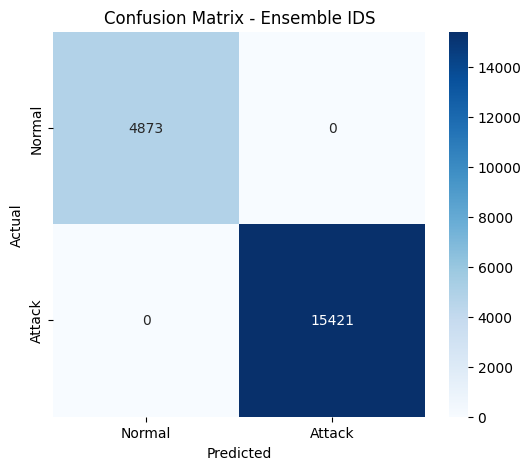

In [9]:
# ===========================
# CONFUSION MATRIX
# ===========================
cm = confusion_matrix(y_test, pred_ensemble)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble IDS")
plt.show()


In [10]:
os.makedirs("models", exist_ok=True)

with open("models/ensemble_ids.pkl", "wb") as f:
    pickle.dump(ensemble, f)

print("\nModel saved successfully: models/ensemble_ids.pkl")



Model saved successfully: models/ensemble_ids.pkl


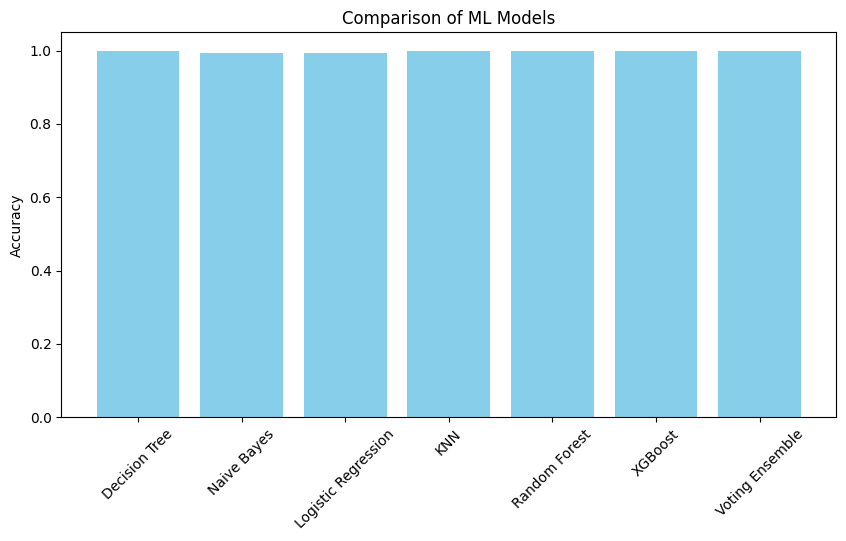


Final Accuracy Summary:
Decision Tree: 100.00%
Naive Bayes: 99.37%
Logistic Regression: 99.34%
KNN: 99.79%
Random Forest: 99.98%
XGBoost: 100.00%
Voting Ensemble: 100.00%


In [11]:
# ===========================
# MODEL COMPARISON
# ===========================
plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Comparison of ML Models")
plt.show()

print("\nFinal Accuracy Summary:")
for model, acc in results.items():
    print(f"{model}: {acc*100:.2f}%")


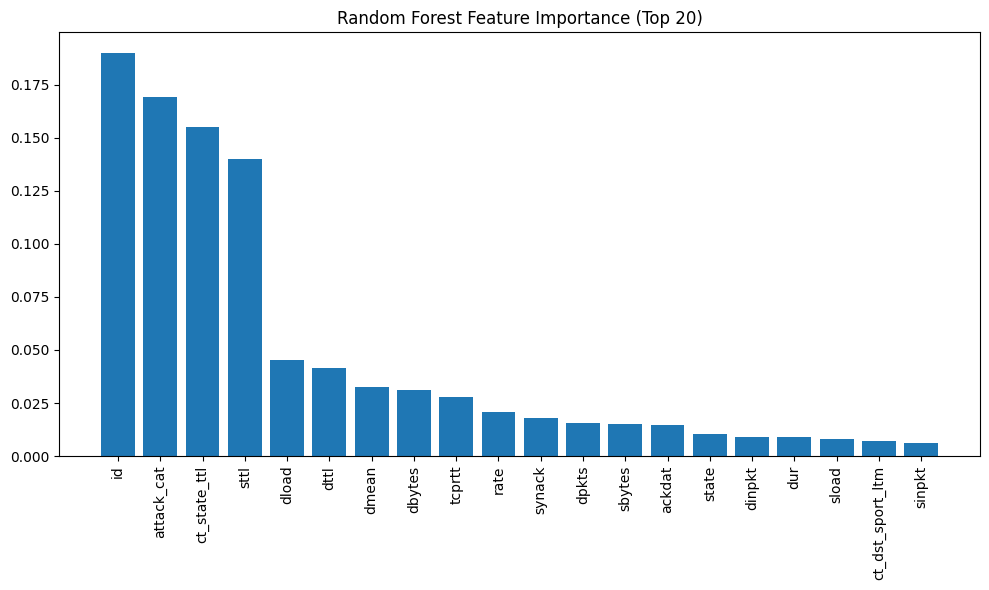

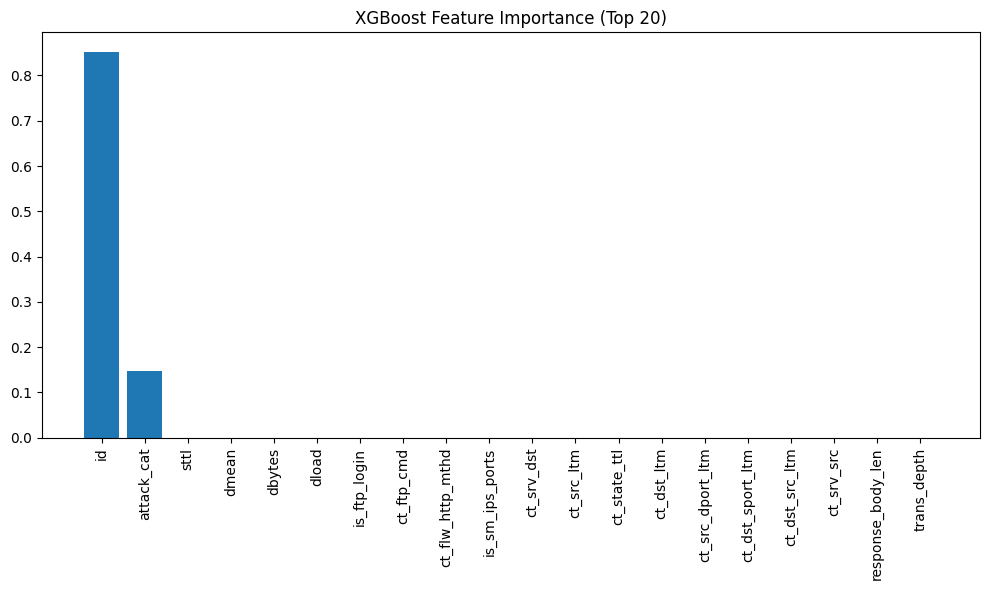

In [12]:
# =====================================================
# FEATURE IMPORTANCE — RANDOM FOREST
# =====================================================
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importance (Top 20)")
plt.bar(range(20), importances_rf[indices_rf][:20])
plt.xticks(range(20), X.columns[indices_rf][:20], rotation=90)
plt.tight_layout()
plt.show()

# =====================================================
# FEATURE IMPORTANCE — XGBOOST
# =====================================================
importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10,6))
plt.title("XGBoost Feature Importance (Top 20)")
plt.bar(range(20), importances_xgb[indices_xgb][:20])
plt.xticks(range(20), X.columns[indices_xgb][:20], rotation=90)
plt.tight_layout()
plt.show()
